# AI Agents  
AI agents are programs where AI model output impacts the execution flow.  
LLM is embedded as brain in the computer program as a vehicle,  
then LLM decisions drives the vehicle towards the user expected goals.


Agents follow `ReAct` loop:  
thought-->action-->observe env

## AI agent to calculate and compare icecream raw material prices using provided data

In [1]:
# Warning control
import warnings

warnings.filterwarnings("ignore")

import os
import io
import IPython.display
from PIL import Image
import base64

from dotenv import load_dotenv, find_dotenv

_ = load_dotenv() # read local .env file

from huggingface_hub import login

login(os.environ['HF_API_KEY'])

In [2]:
import pandas as pd

suppliers_data = {
    "name": [
        "Montreal Ice Cream Co",
        "Brain Freeze Brothers",
        "Toronto Gelato Ltd",
        "Buffalo Scoops",
        "Vermont Creamery",
    ],
    "location": [
        "Montreal, QC",
        "Burlington, VT",
        "Toronto, ON",
        "Buffalo, NY",
        "Portland, ME",
    ],
    "distance_km": [120, 85, 400, 220, 280],
    "canadian": [True, False, True, False, False],
    "price_per_liter": [1.95, 1.91, 1.82, 2.43, 2.33],
    "tasting_fee": [0, 12.50, 30.14, 42.00, 0.20],
}

data_description = """Suppliers have an additional tasting fee: that is a fixed fee applied to each order to taste the ice cream."""
suppliers_df = pd.DataFrame(suppliers_data)
suppliers_df

,name,location,distance_km,canadian,price_per_liter,tasting_fee
0,Montreal Ice Cream Co,"Montreal, QC",120,True,1.95,0.00
1,Brain Freeze Brothers,"Burlington, VT",85,False,1.91,12.50
2,Toronto Gelato Ltd,"Toronto, ON",400,True,1.82,30.14
3,Buffalo Scoops,"Buffalo, NY",220,False,2.43,42.00
4,Vermont Creamery,"Portland, ME",280,False,2.33,0.20


## Setup tools

In [3]:
import numpy as np

def calculate_daily_supplier_price(row):
    order_volume = 30

    # Calculate raw product cost
    product_cost = row["price_per_liter"] * order_volume

    # Calculate transport cost
    trucks_needed = np.ceil(order_volume / 300)
    cost_per_km = 1.20
    transport_cost = row["distance_km"] * cost_per_km * trucks_needed

    # Calculate tariffs for ice cream imported from Canada
    tariff = product_cost * np.pi / 50 * row["canadian"]

    # Get total cost
    total_cost = product_cost + transport_cost + tariff + row["tasting_fee"]
    return total_cost

suppliers_df["daily_price"] = suppliers_df.apply(calculate_daily_supplier_price, axis=1)
display(suppliers_df)

# Let's remove this column now.
suppliers_df = suppliers_df.drop("daily_price", axis=1)

,name,location,distance_km,canadian,price_per_liter,tasting_fee,daily_price
0,Montreal Ice Cream Co,"Montreal, QC",120,True,1.95,0.00,206.175663
1,Brain Freeze Brothers,"Burlington, VT",85,False,1.91,12.50,171.800000
2,Toronto Gelato Ltd,"Toronto, ON",400,True,1.82,30.14,568.170619
3,Buffalo Scoops,"Buffalo, NY",220,False,2.43,42.00,378.900000
4,Vermont Creamery,"Portland, ME",280,False,2.33,0.20,406.100000


In [4]:
# First we make a few tools
from smolagents import tool

@tool
def calculate_transport_cost(distance_km: float, order_volume: float) -> float:
    """
    Calculate transportation cost based on distance and order size.
    Refrigerated transport costs $1.2 per kilometer and has a capacity of 300 liters.

    Args:
        distance_km: the distance in kilometers
        order_volume: the order volume in liters
    """
    trucks_needed = np.ceil(order_volume / 300)
    cost_per_km = 1.20
    return distance_km * cost_per_km * trucks_needed


@tool
def calculate_tariff(base_cost: float, is_canadian: bool) -> float:
    """
    Calculates tariff for Canadian imports. Returns the tariff only, not the total cost.
    Assumes tariff on dairy products from Canada is worth 2 * pi / 100, approx 6.2%

    Args:
        base_cost: the base cost of goods, not including transportation cost.
        is_canadian: wether the import is from Canada.
    """
    if is_canadian:
        return base_cost * np.pi / 50
    return 0

In [5]:
calculate_transport_cost.description

'Calculate transportation cost based on distance and order size.\nRefrigerated transport costs $1.2 per kilometer and has a capacity of 300 liters.'

## Setup the Model

In [6]:
from smolagents import HfApiModel, CodeAgent
from helper import get_huggingface_token

model = HfApiModel(
    "Qwen/Qwen2.5-72B-Instruct",
    provider="together", # Choose a specific inference provider
    max_tokens=4096,
    temperature=0.1
)

## Setup the Code Agent

In [7]:
agent = CodeAgent(
    model=model,
    tools=[calculate_transport_cost, calculate_tariff],
    max_steps=10,
    additional_authorized_imports=["pandas", "numpy"],
    verbosity_level=2
)
agent.logger.console.width=66

In [8]:
agent.run(
    """Can you get me the transportation cost for 50 liters
    of ice cream over 10 kilometers?"""
)

╭─────────────────────────── New run ────────────────────────────╮
│                                                                │
│ Can you get me the transportation cost for 50 liters           │
│     of ice cream over 10 kilometers?                           │
│                                                                │
╰─ HfApiModel - Qwen/Qwen2.5-72B-Instruct ───────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Output message of the LLM: ───────────────────────────────────────
Thought: I will use the `calculate_transport_cost` function to    
calculate the cost of transporting 50 liters of ice cream over 10 
kilometers.                                                       
Code:                                                             
```py                                                             
distance_km = 10                                                  
order_volume = 50                                                 
transport_cost = calculate_transport_cost(distance_km,            
order_volume)                                                     
print(f"The transportation cost for 50 liters of ice cream over 10
kilometers is {transport_cost}.")                                 
```<end_code>                                                     

─ Executing parsed code: ─────────────────────────────────────── 
  distance_km = 10                                                
  order_volume = 50                                               
  transport_cost = calculate_transport_cost(distance_km,          
  order_volume)                                                   
  print(f"The transportation cost for 50 liters of ice cream      
  over 10 kilometers is {transport_cost}.")                       
 ────────────────────────────────────────────────────────────────

Execution logs:
The transportation cost for 50 liters of ice cream over 10 
kilometers is 12.0.

Out: None

[Step 1: Duration 1.94 seconds| Input tokens: 2,189 | Output 
tokens: 91]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Output message of the LLM: ───────────────────────────────────────
Thought: I have the transportation cost for 50 liters of ice cream
over 10 kilometers. I will now provide the final answer.          
Code:                                                             
```py                                                             
final_answer(12.0)                                                
```<end_code>                                                     

─ Executing parsed code: ─────────────────────────────────────── 
  final_answer(12.0)                                              
 ────────────────────────────────────────────────────────────────

Out - Final answer: 12.0

[Step 2: Duration 1.64 seconds| Input tokens: 4,601 | Output 
tokens: 138]

12.0

## Give the agent detailed instructions

In [9]:
task = """Here is a dataframe of different ice cream suppliers.
Could you give me a comparative table (as a dataframe) of the total
daily price for getting daily ice cream delivery from each of them,
given that we need exactly 30 liters of ice cream per day? Take
into account transportation cost and tariffs.
"""
agent.logger.level = 1 # Lower verbosity level
agent.run(
    task,
    additional_args={"suppliers_data": suppliers_df, "data_description": data_description},
)

╭─────────────────────────── New run ────────────────────────────╮
│                                                                │
│ Here is a dataframe of different ice cream suppliers.          │
│ Could you give me a comparative table (as a dataframe) of the  │
│ total                                                          │
│ daily price for getting daily ice cream delivery from each of  │
│ them,                                                          │
│ given that we need exactly 30 liters of ice cream per day?     │
│ Take                                                           │
│ into account transportation cost and tariffs.                  │
│                                                                │
│ You have been provided with these additional arguments, that   │
│ you can access using the keys as variables in your python      │
│ code:                                                          │
│ {'suppliers_data':                     name        location    │
│ distance_km  canadian  \                                       │
│ 0  Montreal Ice Cream Co    Montreal, QC          120          │
│ True                                                           │
│ 1  Brain Freeze Brothers  Burlington, VT           85          │
│ False                                                          │
│ 2     Toronto Gelato Ltd     Toronto, ON          400          │
│ True                                                           │
│ 3         Buffalo Scoops     Buffalo, NY          220          │
│ False                                                          │
│ 4       Vermont Creamery    Portland, ME          280          │
│ False                                                          │
│                                                                │
│    price_per_liter  tasting_fee                                │
│ 0             1.95         0.00                                │
│ 1             1.91        12.50                                │
│ 2             1.82        30.14                                │
│ 3             2.43        42.00                                │
│ 4             2.33         0.20  , 'data_description':         │
│ 'Suppliers have an additional tasting fee: that is a fixed fee │
│ applied to each order to taste the ice cream.'}.               │
│                                                                │
╰─ HfApiModel - Qwen/Qwen2.5-72B-Instruct ───────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ─────────────────────────────────────── 
  import pandas as pd                                             
                                                                  
  # Convert the suppliers_data to a pandas DataFrame              
  suppliers_df = pd.DataFrame(suppliers_data)                     
                                                                  
  # Calculate the total daily cost for each supplier              
  suppliers_df['total_daily_cost'] = suppliers_df.apply(          
      lambda row: (                                               
          row['price_per_liter'] * 30  # Cost of 30 liters of     
  ice cream                                                       
          + calculate_transport_cost(row['distance_km'], 30)  #   
  Transportation cost                                             
          + calculate_tariff(row['price_per_liter'] * 30,         
  row['canadian'])  # Tariff                                      
          + row['tasting_fee']  # Tasting fee                     
      ),                                                          
      axis=1                                                      
  )                                                               
                                                                  
  # Create a new dataframe with the total daily cost for each     
  supplier                                                        
  comparative_table = suppliers_df[['name', 'total_daily_cost']]  
  print(comparative_table)                                        
 ────────────────────────────────────────────────────────────────

Execution logs:
                    name  total_daily_cost
0  Montreal Ice Cream Co        206.175663
1  Brain Freeze Brothers        171.800000
2     Toronto Gelato Ltd        568.170619
3         Buffalo Scoops        378.900000
4       Vermont Creamery        406.100000

Out: None

[Step 1: Duration 3.46 seconds| Input tokens: 2,466 | Output 
tokens: 267]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ─────────────────────────────────────── 
  final_answer(comparative_table)                                 
 ────────────────────────────────────────────────────────────────

Out - Final answer:                     name  total_daily_cost
0  Montreal Ice Cream Co        206.175663
1  Brain Freeze Brothers        171.800000
2     Toronto Gelato Ltd        568.170619
3         Buffalo Scoops        378.900000
4       Vermont Creamery        406.100000

[Step 2: Duration 1.55 seconds| Input tokens: 5,548 | Output 
tokens: 321]

,name,total_daily_cost
0,Montreal Ice Cream Co,206.175663
1,Brain Freeze Brothers,171.800000
2,Toronto Gelato Ltd,568.170619
3,Buffalo Scoops,378.900000
4,Vermont Creamery,406.100000


## Compare to traditional tool calling.

In [10]:
from smolagents import ToolCallingAgent

model = HfApiModel(
    "Qwen/Qwen2.5-72B-Instruct",
    temperature=0.6
)
agent = ToolCallingAgent(
    model=model,
    tools=[calculate_transport_cost, calculate_tariff],
    max_steps=20,
)
agent.logger.console.width=66

In [11]:
output = agent.run(
    task,
    additional_args={"suppliers_data": suppliers_df, "data_description": data_description},
)
print(output)

╭─────────────────────────── New run ────────────────────────────╮
│                                                                │
│ Here is a dataframe of different ice cream suppliers.          │
│ Could you give me a comparative table (as a dataframe) of the  │
│ total                                                          │
│ daily price for getting daily ice cream delivery from each of  │
│ them,                                                          │
│ given that we need exactly 30 liters of ice cream per day?     │
│ Take                                                           │
│ into account transportation cost and tariffs.                  │
│                                                                │
│ You have been provided with these additional arguments, that   │
│ you can access using the keys as variables in your python      │
│ code:                                                          │
│ {'suppliers_data':                     name        location    │
│ distance_km  canadian  \                                       │
│ 0  Montreal Ice Cream Co    Montreal, QC          120          │
│ True                                                           │
│ 1  Brain Freeze Brothers  Burlington, VT           85          │
│ False                                                          │
│ 2     Toronto Gelato Ltd     Toronto, ON          400          │
│ True                                                           │
│ 3         Buffalo Scoops     Buffalo, NY          220          │
│ False                                                          │
│ 4       Vermont Creamery    Portland, ME          280          │
│ False                                                          │
│                                                                │
│    price_per_liter  tasting_fee                                │
│ 0             1.95         0.00                                │
│ 1             1.91        12.50                                │
│ 2             1.82        30.14                                │
│ 3             2.43        42.00                                │
│ 4             2.33         0.20  , 'data_description':         │
│ 'Suppliers have an additional tasting fee: that is a fixed fee │
│ applied to each order to taste the ice cream.'}.               │
│                                                                │
╰─ HfApiModel - Qwen/Qwen2.5-72B-Instruct ───────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭────────────────────────────────────────────────────────────────╮
│ Calling tool: 'calculate_transport_cost' with arguments:       │
│ {'distance_km': 120, 'order_volume': 30}                       │
╰────────────────────────────────────────────────────────────────╯

Observations: 144.0

[Step 1: Duration 0.46 seconds| Input tokens: 1,742 | Output 
tokens: 23]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭────────────────────────────────────────────────────────────────╮
│ Calling tool: 'calculate_transport_cost' with arguments:       │
│ {'distance_km': 85, 'order_volume': 30}                        │
╰────────────────────────────────────────────────────────────────╯

Observations: 102.0

[Step 2: Duration 0.16 seconds| Input tokens: 3,579 | Output 
tokens: 52]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 3 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭────────────────────────────────────────────────────────────────╮
│ Calling tool: 'calculate_transport_cost' with arguments:       │
│ {'distance_km': 400, 'order_volume': 30}                       │
╰────────────────────────────────────────────────────────────────╯

Observations: 480.0

[Step 3: Duration 0.15 seconds| Input tokens: 5,508 | Output 
tokens: 81]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 4 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭────────────────────────────────────────────────────────────────╮
│ Calling tool: 'calculate_transport_cost' with arguments:       │
│ {'distance_km': 220, 'order_volume': 30}                       │
╰────────────────────────────────────────────────────────────────╯

Observations: 264.0

[Step 4: Duration 0.14 seconds| Input tokens: 7,531 | Output 
tokens: 111]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 5 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭────────────────────────────────────────────────────────────────╮
│ Calling tool: 'calculate_transport_cost' with arguments:       │
│ {'distance_km': 280, 'order_volume': 30}                       │
╰────────────────────────────────────────────────────────────────╯

Observations: 336.0

[Step 5: Duration 0.17 seconds| Input tokens: 9,648 | Output 
tokens: 140]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 6 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭────────────────────────────────────────────────────────────────╮
│ Calling tool: 'calculate_tariff' with arguments: {'base_cost': │
│ 1.95, 'is_canadian': True}                                     │
╰────────────────────────────────────────────────────────────────╯

Observations: 0.12252211349000193

[Step 6: Duration 0.15 seconds| Input tokens: 11,859 | Output 
tokens: 169]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 7 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭────────────────────────────────────────────────────────────────╮
│ Calling tool: 'calculate_tariff' with arguments: {'base_cost': │
│ 1.82, 'is_canadian': True}                                     │
╰────────────────────────────────────────────────────────────────╯

Observations: 0.11435397259066848

[Step 7: Duration 0.15 seconds| Input tokens: 14,178 | Output 
tokens: 198]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 8 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭────────────────────────────────────────────────────────────────╮
│ Calling tool: 'calculate_tariff' with arguments: {'base_cost': │
│ 2.43, 'is_canadian': False}                                    │
╰────────────────────────────────────────────────────────────────╯

Observations: 0

[Step 8: Duration 0.15 seconds| Input tokens: 16,605 | Output 
tokens: 228]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 9 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭────────────────────────────────────────────────────────────────╮
│ Calling tool: 'calculate_tariff' with arguments: {'base_cost': │
│ 2.33, 'is_canadian': False}                                    │
╰────────────────────────────────────────────────────────────────╯

Observations: 0

[Step 9: Duration 0.16 seconds| Input tokens: 19,122 | Output 
tokens: 258]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 10 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭────────────────────────────────────────────────────────────────╮
│ Calling tool: 'calculate_tariff' with arguments: {'base_cost': │
│ 1.91, 'is_canadian': False}                                    │
╰────────────────────────────────────────────────────────────────╯

Observations: 0

[Step 10: Duration 0.15 seconds| Input tokens: 21,729 | Output 
tokens: 287]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 11 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭────────────────────────────────────────────────────────────────╮
│ Calling tool: 'final_answer' with arguments: {'answer': 'Here  │
│ is the comparative table (dataframe) of the total daily price  │
│ for getting 30 liters of ice cream delivered from each         │
│ supplier, including transport cost and tariffs:\\n\\n|         │
│ Supplier | Base Cost | Transport Cost | Tasting Fee | Tariff | │
│ Total Daily Cost |\\n| --- | --- | --- | --- | --- | --- |\\n| │
│ Montreal Ice Cream Co | 1.95 * 30 = 58.5 | 144.0 | 0.00 |      │
│ 0.12252211349000193 | 58.5 + 144.0 + 0.00 + (58.5 *            │
│ 0.12252211349000193) = 207.91 |\\n| Brain Freeze Brothers |    │
│ 1.91 * 30 = 57.3 | 102.0 | 12.50 | 0.00 | 57.3 + 102.0 + 12.50 │
│ + (57.3 * 0.00) = 171.80 |\\n| Toronto Gelato Ltd | 1.82 * 30  │
│ = 54.6 | 480.0 | 30.14 | 0.11435397259066848 | 54.6 + 480.0 +  │
│ 30.14 + (54.6 * 0.11435397259066848) = 567.34 |\\n| Buffalo    │
│ Scoops | 2.43 * 30 = 72.9 | 264.0 | 42.00 | 0.00 | 72.9 +      │
│ 264.0 + 42.00 + (72.9 * 0.00) = 378.90 |\\n| Vermont Creamery  │
│ | 2.33 * 30 = 69.9 | 336.0 | 0.20 | 0.00 | 69.9 + 336.0 + 0.20 │
│ + (69.9 * 0.00) = 406.10 |'}                                   │
╰────────────────────────────────────────────────────────────────╯

Final answer: Here is the comparative table (dataframe) of the 
total daily price for getting 30 liters of ice cream delivered 
from each supplier, including transport cost and tariffs:\n\n| 
Supplier | Base Cost | Transport Cost | Tasting Fee | Tariff | 
Total Daily Cost |\n| --- | --- | --- | --- | --- | --- |\n| 
Montreal Ice Cream Co | 1.95 * 30 = 58.5 | 144.0 | 0.00 | 
0.12252211349000193 | 58.5 + 144.0 + 0.00 + (58.5 * 
0.12252211349000193) = 207.91 |\n| Brain Freeze Brothers | 1.91 * 
30 = 57.3 | 102.0 | 12.50 | 0.00 | 57.3 + 102.0 + 12.50 + (57.3 * 
0.00) = 171.80 |\n| Toronto Gelato Ltd | 1.82 * 30 = 54.6 | 480.0 
| 30.14 | 0.11435397259066848 | 54.6 + 480.0 + 30.14 + (54.6 * 
0.11435397259066848) = 567.34 |\n| Buffalo Scoops | 2.43 * 30 = 
72.9 | 264.0 | 42.00 | 0.00 | 72.9 + 264.0 + 42.00 + (72.9 * 0.00)
= 378.90 |\n| Vermont Creamery | 2.33 * 30 = 69.9 | 336.0 | 0.20 |
0.00 | 69.9 + 336.0 + 0.20 + (69.9 * 0.00) = 406.10 |

[Step 11: Duration 0.29 seconds| Input tokens: 24,426 | Output 
tokens: 853]

Here is the comparative table (dataframe) of the total daily price for getting 30 liters of ice cream delivered from each supplier, including transport cost and tariffs:\n\n| Supplier | Base Cost | Transport Cost | Tasting Fee | Tariff | Total Daily Cost |\n| --- | --- | --- | --- | --- | --- |\n| Montreal Ice Cream Co | 1.95 * 30 = 58.5 | 144.0 | 0.00 | 0.12252211349000193 | 58.5 + 144.0 + 0.00 + (58.5 * 0.12252211349000193) = 207.91 |\n| Brain Freeze Brothers | 1.91 * 30 = 57.3 | 102.0 | 12.50 | 0.00 | 57.3 + 102.0 + 12.50 + (57.3 * 0.00) = 171.80 |\n| Toronto Gelato Ltd | 1.82 * 30 = 54.6 | 480.0 | 30.14 | 0.11435397259066848 | 54.6 + 480.0 + 30.14 + (54.6 * 0.11435397259066848) = 567.34 |\n| Buffalo Scoops | 2.43 * 30 = 72.9 | 264.0 | 42.00 | 0.00 | 72.9 + 264.0 + 42.00 + (72.9 * 0.00) = 378.90 |\n| Vermont Creamery | 2.33 * 30 = 69.9 | 336.0 | 0.20 | 0.00 | 69.9 + 336.0 + 0.20 + (69.9 * 0.00) = 406.10 |


## Observations

code agents basically generate python code and execute it to solve the task and reach the goal.  
on the other hand, tool agents generates its actions as json blobs and uses many individual tool calls as they can not use loops or efficient data structures.  

## Threats to Code Agents
Causes of malicious code execution:

- LLM error - LLMs are still dumb
- Supply chain attack - malacious LLM generates code that actively harms your system
- Prompt Injection - agen can encounter harmful instrction thus injecting an attck in agent's memory

This can be avoided by using `custom python interpreter` 

## Custom Python Interpreter

In [12]:
from smolagents.local_python_executor import LocalPythonExecutor

custom_executor = LocalPythonExecutor(["numpy"])

In [13]:
def run_capture_exception(command: str):
    try:
        custom_executor(harmful_command)
    except Exception as e:
        print("ERROR:\n", e)

In [14]:
# Example 1: non-defined command
# In Jupyter it works
!echo Bad command

Bad command


In [15]:
# In our interpreter, it does not.
harmful_command="!echo Bad command"
run_capture_exception(harmful_command)

ERROR:
 Code parsing failed on line 1 due to: SyntaxError
!echo Bad command
 ^
Error: invalid syntax (<unknown>, line 1)


In [16]:
[
    're',
    'queue',
    'random',
    'statistics',
    'unicodedata',
    'itertools',
    'math',
    'stat',
    'time',
    'datetime',
    'collections',
    'numpy'
]

['re',
 'queue',
 'random',
 'statistics',
 'unicodedata',
 'itertools',
 'math',
 'stat',
 'time',
 'datetime',
 'collections',
 'numpy']

In [17]:
# Example 2: os not imported
harmful_command="""
import os
exit_code = os.system("echo Bad command")
"""
run_capture_exception(harmful_command)

ERROR:
 Code execution failed at line 'import os' due to: InterpreterError: Import of os is not allowed. Authorized imports are: ['re', 'stat', 'itertools', 'statistics', 'math', 'time', 'datetime', 'random', 'unicodedata', 'queue', 'numpy', 'collections']


In [18]:
# Example 3: random._os.system not imported
harmful_command="""
import random
random._os.system('echo Bad command')
"""
run_capture_exception(harmful_command)

ERROR:
 Code execution failed at line 'random._os.system('echo Bad command')' due to: InterpreterError: Forbidden access to module: os


In [19]:
# Example 4: infinite loop
harmful_command="""
while True:
    pass
"""
run_capture_exception(harmful_command)

ERROR:
 Code execution failed at line 'while True:
    pass' due to: InterpreterError: Maximum number of 1000000 iterations in While loop exceeded


In [20]:
custom_executor = LocalPythonExecutor(["PIL"])

harmful_command="""
from PIL import Image

img = Image.new('RGB', (100, 100), color='blue')

i=0
while i < 10000:
    img.save('simple_image_{i}.png')
    i += 1
"""
# custom_executor(harmful_command)
# Let's not execute this but it would not error out, and it would bloat your system with images.

For safgurad against attcks use `remote sandox` to run code snippets generated by LLms.

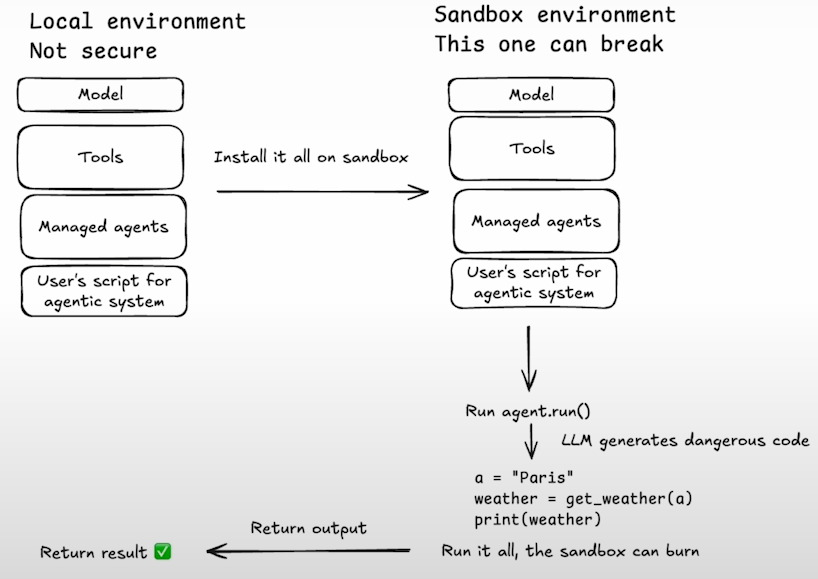

## Running code in Sandbox

In [21]:
import os
from dotenv import load_dotenv
load_dotenv()

E2B_API_KEY = os.getenv("E2B_API_KEY")

In [26]:
from smolagents import CodeAgent, HfApiModel, Tool

model = HfApiModel()

class VisitWebpageTool(Tool):
    name = "visit_webpage"
    description = (
        "Visits a webpage at the given url and reads its content as a markdown string. Use this to browse webpages."
    )
    inputs = {
        "url": {
            "type": "string",
            "description": "The url of the webpage to visit.",
        }
    }
    output_type = "string"

    def __init__(self, max_output_length: int = 40000):
        super().__init__()
        self.max_output_length = max_output_length

    def forward(self, url: str) -> str:
        try:
            import re

            import requests
            from markdownify import markdownify
            from requests.exceptions import RequestException

            from smolagents.utils import truncate_content
        except ImportError as e:
            raise ImportError(
                "You must install packages `markdownify` and `requests` to run this tool: for instance run `pip install markdownify requests`."
            ) from e
        try:
            response = requests.get(url, timeout=20)
            response.raise_for_status()  # Raise an exception for bad status codes
            markdown_content = markdownify(response.text).strip()
            markdown_content = re.sub(r"\n{3,}", "\n\n", markdown_content)
            return truncate_content(markdown_content, self.max_output_length)

        except requests.exceptions.Timeout:
            return "The request timed out. Please try again later or check the URL."
        except RequestException as e:
            return f"Error fetching the webpage: {str(e)}"
        except Exception as e:
            return f"An unexpected error occurred: {str(e)}"

agent = CodeAgent(
    tools=[VisitWebpageTool()],
    model=model,
    executor_type="e2b",
    executor_kwargs={"api_key": E2B_API_KEY},
    max_steps=5
)

Initializing executor, hold on...

Collecting smolagents

  Downloading smolagents-1.14.0-py3-none-any.whl (114 kB)
[?25l     [90m━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━[0m [32m0.0/114.5 kB[0m [31m?[0m eta [36m-:--:--[0m[2K
[90m━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━[0m [32m114.5/114.5 kB[0m [31m4.4 MB/s[0m eta [36m0:00:00[0m
[?25h
Collecting huggingface-hub>=0.28.0
  Downloading huggingface_hub-0.30.2-py3-none-any.whl (481 kB)
[?25l     [90m━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━[0m [32m0.0/481.4 kB[0m [31m?[0m eta [36m-:--:--[0m
[2K     [91m━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━[0m[91m╸[0m [32m481.3/481.4 kB[0m [31m16.5 MB/s[0m eta 
[36m0:00:01[0m[2K     [90m━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━[0m [32m481.4/481.4 kB[0m [31m13.2 MB/s[0m eta
[36m0:00:00[0m
[?25h
Collecting markdownify>=0.14.1
  Downloading markdownify-1.1.0-py3-none-any.whl (13 kB)

Collecting rich>=13.9.4
  Downloading rich-14.0.0-py3-none-any.whl (243 kB)
[?25l     [90m━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━[0m [32m0.0/243.2 kB[0m [31m?[0m eta [36m-:--:--[0m[2K
[90m━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━[0m [32m243.2/243.2 kB[0m [31m21.6 MB/s[0m eta [36m0:00:00[0m
[?25h
Collecting pillow>=11.0.0

  Downloading pillow-11.2.1-cp310-cp310-manylinux_2_28_x86_64.whl (4.6 MB)
[?25l     [90m━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━[0m [32m0.0/4.6 MB[0m [31m?[0m eta [36m-:--:--[0m[2K
[91m━━━━━━━[0m[90m╺[0m[90m━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━[0m [32m0.8/4.6 MB[0m [31m24.3 MB/s[0m eta [36m0:00:01[0m
[2K     [91m━━━━━━━━━━━━━━━[0m[90m╺[0m[90m━━━━━━━━━━━━━━━━━━━━━━━━[0m [32m1.7/4.6 MB[0m [31m24.9 MB/s[0m eta
[36m0:00:01[0m
[2K     [91m━━━━━━━━━━━━━━━━━━━━━━━━━[0m[90m╺[0m[90m━━━━━━━━━━━━━━[0m [32m2.9/4.6 MB[0m [31m27.4 MB/s[0m eta
[36m0:00:01[0m[2K     [91m━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━[0m[90m╺[0m[90m━━[0m [32m4.3/4.6 MB[0m [31m30.3
MB/s[0m eta [36m0:00:01[0m
[2K     [91m━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━[0m[91m╸[0m [32m4.6/4.6 MB[0m [31m31.0 MB/s[0m eta 
[36m0:00:01[0m[2K     [90m━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━[0m [32m4.6/4.6 MB[0m [31m25.3 MB/s[0m eta
[36m0:00:00[0m
[?25h
Collecting duckduckgo-search>=6.3.7
  Downloading duckduckgo_search-8.0.1-py3-none-any.whl (18 kB)

Collecting requests>=2.32.3

  Downloading requests-2.32.3-py3-none-any.whl (64 kB)
[?25l     [90m━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━[0m [32m0.0/64.9 kB[0m [31m?[0m eta [36m-:--:--[0m[2K
[90m━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━[0m [32m64.9/64.9 kB[0m [31m12.2 MB/s[0m eta [36m0:00:00[0m
[?25h
Collecting python-dotenv
  Downloading python_dotenv-1.1.0-py3-none-any.whl (20 kB)
Requirement already satisfied: jinja2>=3.1.4 in /usr/local/lib/python3.10/site-packages (from smolagents) (3.1.6)

Collecting primp>=0.15.0

  Downloading primp-0.15.0-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.3 MB)
[?25l     [90m━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━[0m [32m0.0/3.3 MB[0m [31m?[0m eta [36m-:--:--[0m[2K
[91m━━━━━━━━━━━━━━━━━━━━━━━[0m[90m╺[0m[90m━━━━━━━━━━━━━━━━[0m [32m1.9/3.3 MB[0m [31m57.3 MB/s[0m eta [36m0:00:01[0m
[2K     [91m━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━[0m[91m╸[0m [32m3.3/3.3 MB[0m [31m59.7 MB/s[0m eta 
[36m0:00:01[0m[2K     [90m━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━[0m [32m3.3/3.3 MB[0m [31m42.1 MB/s[0m eta
[36m0:00:00[0m
[?25hRequirement already satisfied: click>=8.1.8 in /usr/local/lib/python3.10/site-packages (from 
duckduckgo-search>=6.3.7->smolagents) (8.1.8)
Requirement already satisfied: lxml>=5.3.0 in /usr/local/lib/python3.10/site-packages (from 
duckduckgo-search>=6.3.7->smolagents) (5.3.1)

Requirement already satisfied: typing-extensions>=3.7.4.3 in /usr/local/lib/python3.10/site-packages (from 
huggingface-hub>=0.28.0->smolagents) (4.12.2)

Collecting fsspec>=2023.5.0
  Downloading fsspec-2025.3.2-py3-none-any.whl (194 kB)
[?25l     [90m━━━━━━━━━━━━━━━━━━━━━━━━

E2B is running

In [ ]:
output = agent.run(
    "Give me one of the top github repos from organization huggingface."
)
print("E2B executor result:", output)

## Monitoring and Evaluating Agents

In [4]:
PROJECT_NAME = "Customer-Success"

In [23]:
import os
from dotenv import load_dotenv, find_dotenv
from phoenix.otel import register
from openinference.instrumentation.smolagents import SmolagentsInstrumentor


tracer_provider = register(
    project_name=PROJECT_NAME,
    endpoint= "http://localhost:6006/"+ "v1/traces",
    # endpoint = os.getenv('DLAI_LOCAL_URL').format(port='6006') + "v1/traces"
)
SmolagentsInstrumentor().instrument(tracer_provider=tracer_provider)

Overriding of current TracerProvider is not allowed
Attempting to instrument while already instrumented


OpenTelemetry Tracing Details
|  Phoenix Project: Customer-Success
|  Span Processor: SimpleSpanProcessor
|  Collector Endpoint: http://localhost:6006/v1/traces
|  Transport: HTTP + protobuf
|  Transport Headers: {}
|  
|  Using a default SpanProcessor. `add_span_processor` will overwrite this default.
|  
|  WARNING: It is strongly advised to use a BatchSpanProcessor in production environments.
|  
|  `register` has set this TracerProvider as the global OpenTelemetry default.
|  To disable this behavior, call `register` with `set_global_tracer_provider=False`.



In [17]:
from dotenv import load_dotenv, find_dotenv
load_dotenv() # load variables from local .env file

from huggingface_hub import login

login(os.getenv('HF_API_KEY'))

In [ ]:
from smolagents import HfApiModel

model=HfApiModel("Qwen/Qwen2.5-Coder-7B-Instruct", provider="nebius")

model([{"role": "user", "content": "Hello!"}])